## Task 4: Portfolio Optimization Based on Forecast

In this task, we aim to use the forecasted data generated in Task 3 to strategically optimize a sample investment portfolio containing three assets: Tesla (TSLA), Vanguard Total Bond Market ETF (BND), and S&P 500 ETF (SPY). The objective is to balance potential returns with minimized risk by leveraging predicted trends for each asset. We will calculate and analyze the annualized return and risk (volatility) of each asset based on forecasted prices, assess correlations through a covariance matrix, and determine the optimal asset allocation using portfolio optimization techniques to maximize the Sharpe Ratio (risk-adjusted return). Through this approach, we will explore adjustments like increasing bond allocations if Tesla's volatility is expected to rise, ultimately enhancing portfolio resilience. The task concludes with visualizations of the portfolio’s expected performance and an evaluation of key metrics, including expected returns, volatility, Value at Risk (VaR), and the Sharpe Ratio.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.2243 - val_loss: 0.0173
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0123 - val_loss: 0.0142
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0090 - val_loss: 0.0132
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0084 - val_loss: 0.0113
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0072 - val_loss: 0.0111
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0076 - val_loss: 0.0102
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0073 - val_loss: 0.0099
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0076 - val_loss: 0.0093
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0068 - val_loss: 0.0094
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0063 - val_loss: 0.0087
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Mean Absolute Error (MAE): 0.22460462196003975
Root Mean Squared Error (RMSE): 0.2821376402896614
Mean Absolute Percentage Error (MAPE): 0.0032099435578989565


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


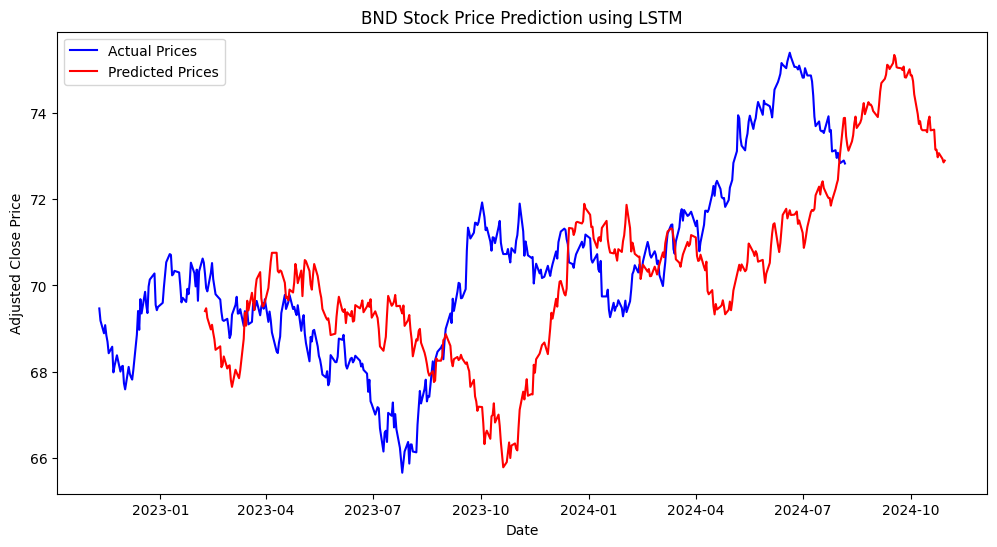

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Load and prepare the dataset
df = pd.read_csv('/content/drive/MyDrive/data/BND_historical_data.csv', parse_dates=['Date'], index_col='Date')
y = df['Adj Close']

# Scaling the data for better prediction stability
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Convert time series data to supervised learning format for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length and split the data into training and testing sets (80% training, 20% testing)
sequence_length = 60
train_data = y_scaled[:int(0.8 * len(y_scaled))]
test_data = y_scaled[int(0.8 * len(y_scaled)):]

# Create sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# Save the model for future use
model_path = "/content/drive/MyDrive/data/lstm_model_BND.h5"
model.save(model_path)

# Make predictions on the test set
predictions = model.predict(X_test)

# Rescale predictions and test data back to original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluate the model
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
rmse = mean_squared_error(y_test_rescaled, predictions_rescaled, squared=False)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Plot actual vs predicted for visual evaluation
plt.figure(figsize=(12, 6))
# The x-axis for the actual data needs to be adjusted
# to match the number of data points in y_test_rescaled.
# We slice the date index using the length of y_test_rescaled
# and offset it by the starting point of the test data.
plt.plot(y.index[int(0.8 * len(y)):int(0.8 * len(y)) + len(y_test_rescaled)],
         y_test_rescaled, label='Actual Prices', color='blue')

plt.plot(y.index[int(0.8 * len(y)) + sequence_length:],
         predictions_rescaled, label='Predicted Prices', color='red')

plt.title('BND Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━

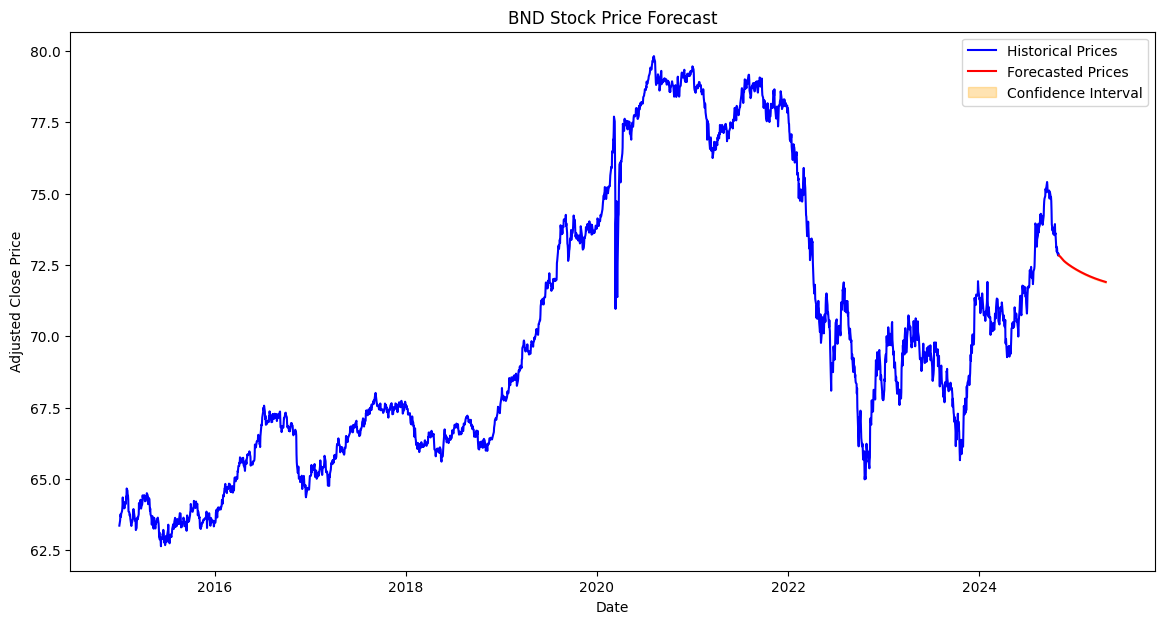

Trend Analysis:
- Check for an overall trend in forecasted prices (upward, downward, or stable).
- Observe any irregular patterns or anomalies in the forecast.
Volatility and Risk:
- Review the confidence intervals to understand uncertainty and potential volatility.
- Highlight periods of potential volatility or stable movement.
Market Opportunities and Risks:
- Use trend analysis to identify potential market opportunities or risks based on expected trends.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# Load the trained LSTM model
model_path = "/content/drive/MyDrive/data/lstm_model_BND.h5"
model = load_model(model_path)

# Load the dataset (assuming the dataset contains the 'Date' and 'Adj Close' columns)
df = pd.read_csv('/content/drive/MyDrive/data/BND_historical_data.csv', parse_dates=['Date'], index_col='Date')
y = df['Adj Close']

# Scale data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Prepare data for LSTM prediction (e.g., using a window of 60 days for each prediction step)
sequence_length = 60
input_data = []
for i in range(len(y_scaled) - sequence_length):
    input_data.append(y_scaled[i: i + sequence_length])

input_data = np.array(input_data)

# Predict future prices (6-12 months, here we assume 252 trading days per year)
forecast_days = 180  # Approx. 6 months of trading days
predictions_scaled = []

# Use the last available sequence to start forecasting
current_sequence = y_scaled[-sequence_length:].reshape(1, sequence_length, 1)

# Predict the next 'forecast_days' steps
for _ in range(forecast_days):
    next_pred = model.predict(current_sequence)[0]
    predictions_scaled.append(next_pred)
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_pred]], axis=1)

# Rescale predictions back to the original scale
predictions = scaler.inverse_transform(predictions_scaled).flatten()

# Generate future dates
last_date = df.index[-1]
forecast_dates = [last_date + timedelta(days=i) for i in range(1, forecast_days + 1)]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted Price': predictions})

# Save predictions to a CSV file
forecast_df.to_csv("/content/drive/MyDrive/data/predicted_values_BND.csv", index=False)

# Plot historical and forecasted prices
plt.figure(figsize=(14, 7))
plt.plot(df.index, y, label='Historical Prices', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Predicted Price'], label='Forecasted Prices', color='red')

# Optionally, add confidence intervals based on the predicted values' variation
# (confidence intervals are typically complex with LSTM; here is an illustrative approach)
upper_bound = predictions + (np.std(predictions) * 0.1)  # Adjust as needed for your model's error range
lower_bound = predictions - (np.std(predictions) * 0.1)

plt.fill_between(forecast_df['Date'], lower_bound, upper_bound, color='orange', alpha=0.3, label='Confidence Interval')

# Labels and title
plt.title("BND Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()

# Interpretation of Results
print("Trend Analysis:")
print("- Check for an overall trend in forecasted prices (upward, downward, or stable).")
print("- Observe any irregular patterns or anomalies in the forecast.")
print("Volatility and Risk:")
print("- Review the confidence intervals to understand uncertainty and potential volatility.")
print("- Highlight periods of potential volatility or stable movement.")
print("Market Opportunities and Risks:")
print("- Use trend analysis to identify potential market opportunities or risks based on expected trends.")

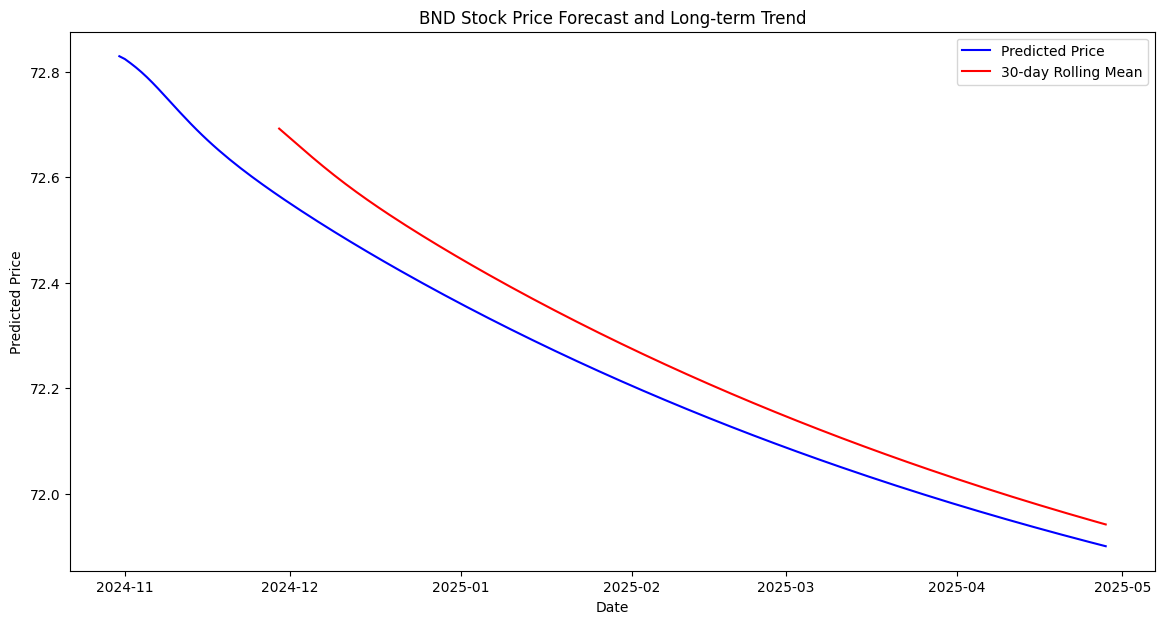

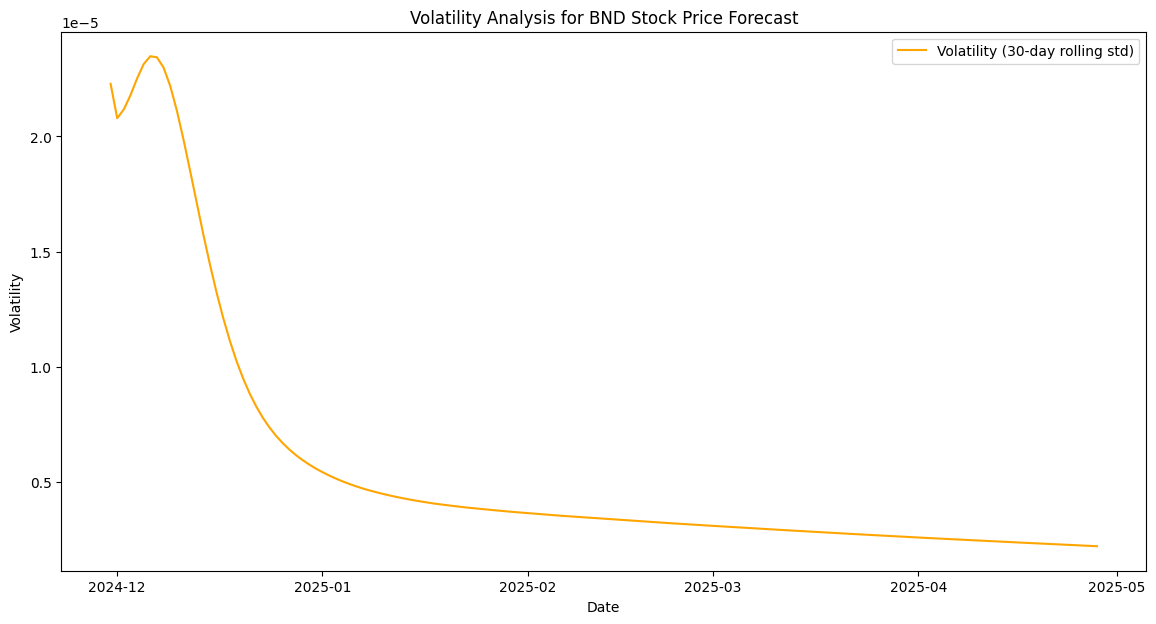

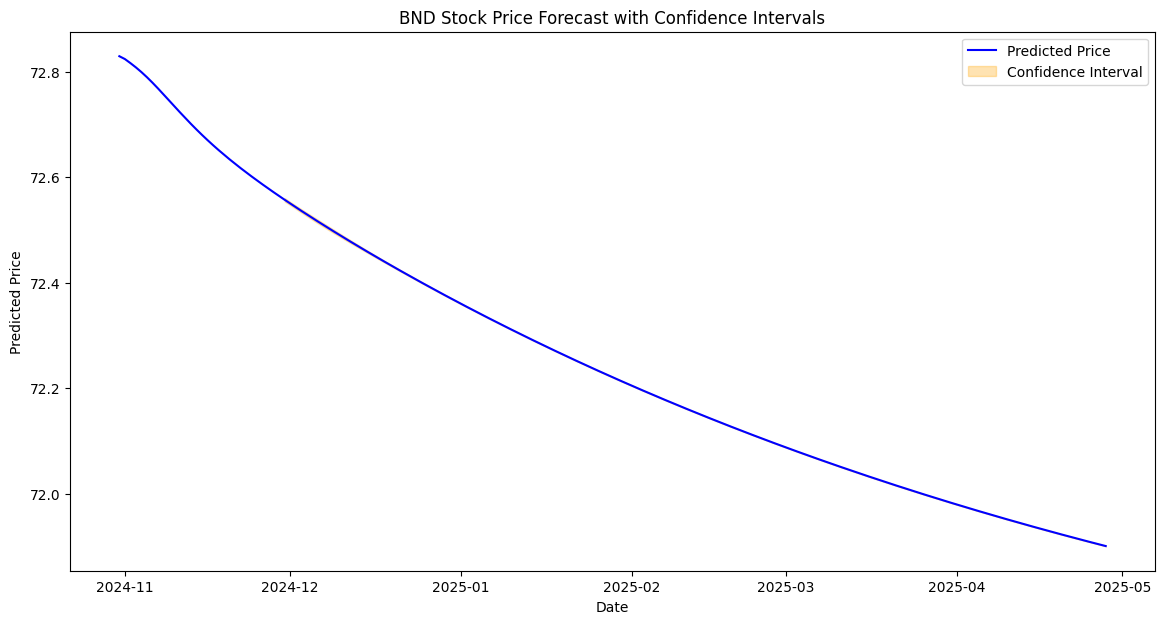

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the data
df_1 = pd.read_csv('/content/drive/MyDrive/data/predicted_values_BND.csv', parse_dates=['Date'], index_col='Date')

# Calculate the rolling mean to analyze the trend
df_1['Rolling Mean'] = df_1['Predicted Price'].rolling(window=30).mean()

# Calculate the daily returns to observe volatility
df_1['Returns'] = df_1['Predicted Price'].pct_change()

# Calculate standard deviation of returns for a measure of volatility
df_1['Volatility'] = df_1['Returns'].rolling(window=30).std()

# Plotting Predicted Price and Rolling Mean for trend analysis
plt.figure(figsize=(14, 7))
plt.plot(df_1['Predicted Price'], label='Predicted Price', color='blue')
plt.plot(df_1['Rolling Mean'], label='30-day Rolling Mean', color='red')
plt.title("BND Stock Price Forecast and Long-term Trend")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

# Plotting Volatility
plt.figure(figsize=(14, 7))
plt.plot(df_1['Volatility'], label='Volatility (30-day rolling std)', color='orange')
plt.title("Volatility Analysis for BND Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Interpretation of Volatility and Risk
# Confidence intervals based on a normal distribution assumption for simplicity
confidence_interval = 1.96  # 95% confidence interval
df_1['Upper Bound'] = df_1['Predicted Price'] + (confidence_interval * df_1['Volatility'] * df_1['Predicted Price'])
df_1['Lower Bound'] = df_1['Predicted Price'] - (confidence_interval * df_1['Volatility'] * df_1['Predicted Price'])

# Plotting with Confidence Intervals
plt.figure(figsize=(14, 7))
plt.plot(df_1['Predicted Price'], label='Predicted Price', color='blue')
plt.fill_between(df_1.index, df_1['Lower Bound'], df_1['Upper Bound'], color='orange', alpha=0.3, label='Confidence Interval')
plt.title("BND Stock Price Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

## Next we proceed to the prediction of the SPY stock.

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1834 - val_loss: 0.1568
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0062 - val_loss: 0.1232
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - val_loss: 0.0812
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0041 - val_loss: 0.0363
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0044 - val_loss: 0.0358
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0119
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 0.0125
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - val_loss: 0.0106
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0040 - val_loss: 0.0184
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - val_loss: 0.0151
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0032 - val_loss: 0.0206
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0029

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Mean Absolute Error (MAE): 7.736218964062501
Root Mean Squared Error (RMSE): 9.405471366030632
Mean Absolute Percentage Error (MAPE): 0.015511055452605619


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


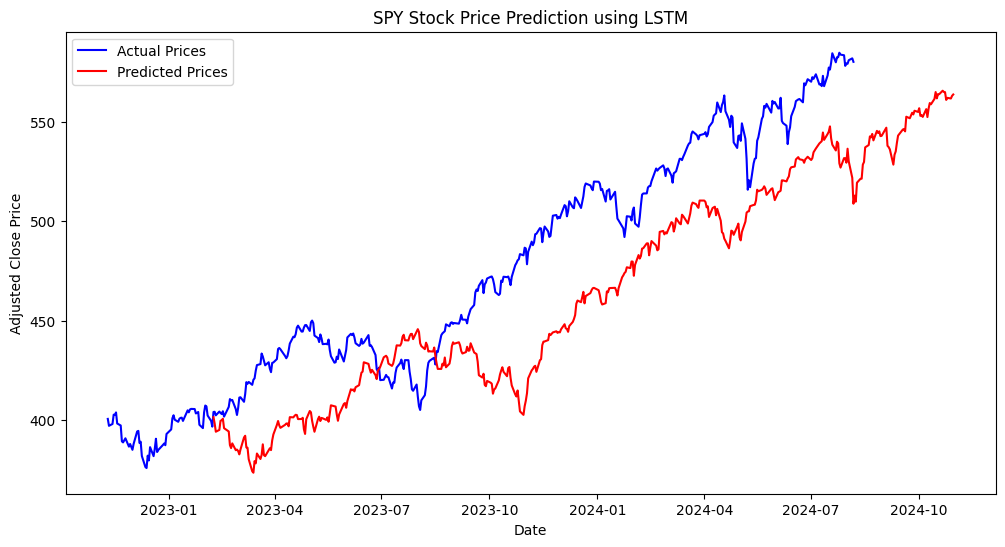

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Load and prepare the dataset
df = pd.read_csv('/content/drive/MyDrive/data/SPY_historical_data.csv', parse_dates=['Date'], index_col='Date')
y = df['Adj Close']

# Scaling the data for better prediction stability
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Convert time series data to supervised learning format for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length and split the data into training and testing sets (80% training, 20% testing)
sequence_length = 60
train_data = y_scaled[:int(0.8 * len(y_scaled))]
test_data = y_scaled[int(0.8 * len(y_scaled)):]

# Create sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# Save the model for future use
model_path = "/content/drive/MyDrive/data/lstm_model_SPY.h5"
model.save(model_path)

# Make predictions on the test set
predictions = model.predict(X_test)

# Rescale predictions and test data back to original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluate the model
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
rmse = mean_squared_error(y_test_rescaled, predictions_rescaled, squared=False)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Plot actual vs predicted for visual evaluation
plt.figure(figsize=(12, 6))
# The x-axis for the actual data needs to be adjusted
# to match the number of data points in y_test_rescaled.
# We slice the date index using the length of y_test_rescaled
# and offset it by the starting point of the test data.
plt.plot(y.index[int(0.8 * len(y)):int(0.8 * len(y)) + len(y_test_rescaled)],
         y_test_rescaled, label='Actual Prices', color='blue')

plt.plot(y.index[int(0.8 * len(y)) + sequence_length:],
         predictions_rescaled, label='Predicted Prices', color='red')

plt.title('SPY Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

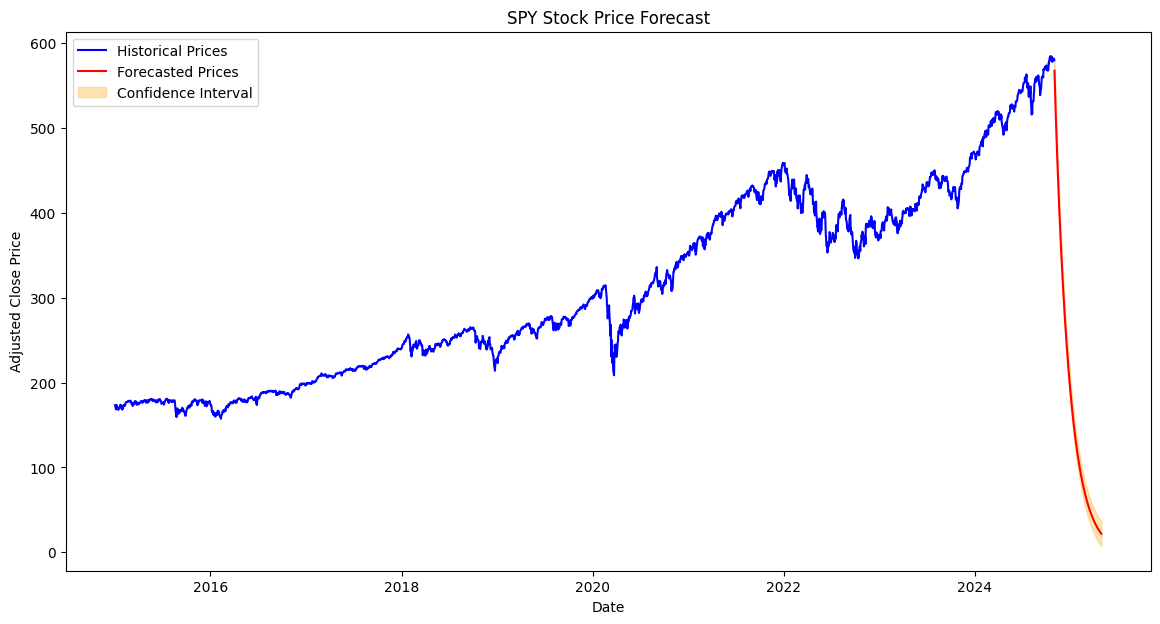

Trend Analysis:
- Check for an overall trend in forecasted prices (upward, downward, or stable).
- Observe any irregular patterns or anomalies in the forecast.
Volatility and Risk:
- Review the confidence intervals to understand uncertainty and potential volatility.
- Highlight periods of potential volatility or stable movement.
Market Opportunities and Risks:
- Use trend analysis to identify potential market opportunities or risks based on expected trends.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# Load the trained LSTM model
model_path = "/content/drive/MyDrive/data/lstm_model_SPY.h5"
model = load_model(model_path)

# Load the dataset (assuming the dataset contains the 'Date' and 'Adj Close' columns)
df = pd.read_csv('/content/drive/MyDrive/data/SPY_historical_data.csv', parse_dates=['Date'], index_col='Date')
y = df['Adj Close']

# Scale data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Prepare data for LSTM prediction (e.g., using a window of 60 days for each prediction step)
sequence_length = 60
input_data = []
for i in range(len(y_scaled) - sequence_length):
    input_data.append(y_scaled[i: i + sequence_length])

input_data = np.array(input_data)

# Predict future prices (6-12 months, here we assume 252 trading days per year)
forecast_days = 180  # Approx. 6 months of trading days
predictions_scaled = []

# Use the last available sequence to start forecasting
current_sequence = y_scaled[-sequence_length:].reshape(1, sequence_length, 1)

# Predict the next 'forecast_days' steps
for _ in range(forecast_days):
    next_pred = model.predict(current_sequence)[0]
    predictions_scaled.append(next_pred)
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_pred]], axis=1)

# Rescale predictions back to the original scale
predictions = scaler.inverse_transform(predictions_scaled).flatten()

# Generate future dates
last_date = df.index[-1]
forecast_dates = [last_date + timedelta(days=i) for i in range(1, forecast_days + 1)]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted Price': predictions})

# Save predictions to a CSV file
forecast_df.to_csv("/content/drive/MyDrive/data/predicted_values_SPY.csv", index=False)

# Plot historical and forecasted prices
plt.figure(figsize=(14, 7))
plt.plot(df.index, y, label='Historical Prices', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Predicted Price'], label='Forecasted Prices', color='red')

# Optionally, add confidence intervals based on the predicted values' variation
# (confidence intervals are typically complex with LSTM; here is an illustrative approach)
upper_bound = predictions + (np.std(predictions) * 0.1)  # Adjust as needed for your model's error range
lower_bound = predictions - (np.std(predictions) * 0.1)

plt.fill_between(forecast_df['Date'], lower_bound, upper_bound, color='orange', alpha=0.3, label='Confidence Interval')

# Labels and title
plt.title("SPY Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()

# Interpretation of Results
print("Trend Analysis:")
print("- Check for an overall trend in forecasted prices (upward, downward, or stable).")
print("- Observe any irregular patterns or anomalies in the forecast.")
print("Volatility and Risk:")
print("- Review the confidence intervals to understand uncertainty and potential volatility.")
print("- Highlight periods of potential volatility or stable movement.")
print("Market Opportunities and Risks:")
print("- Use trend analysis to identify potential market opportunities or risks based on expected trends.")

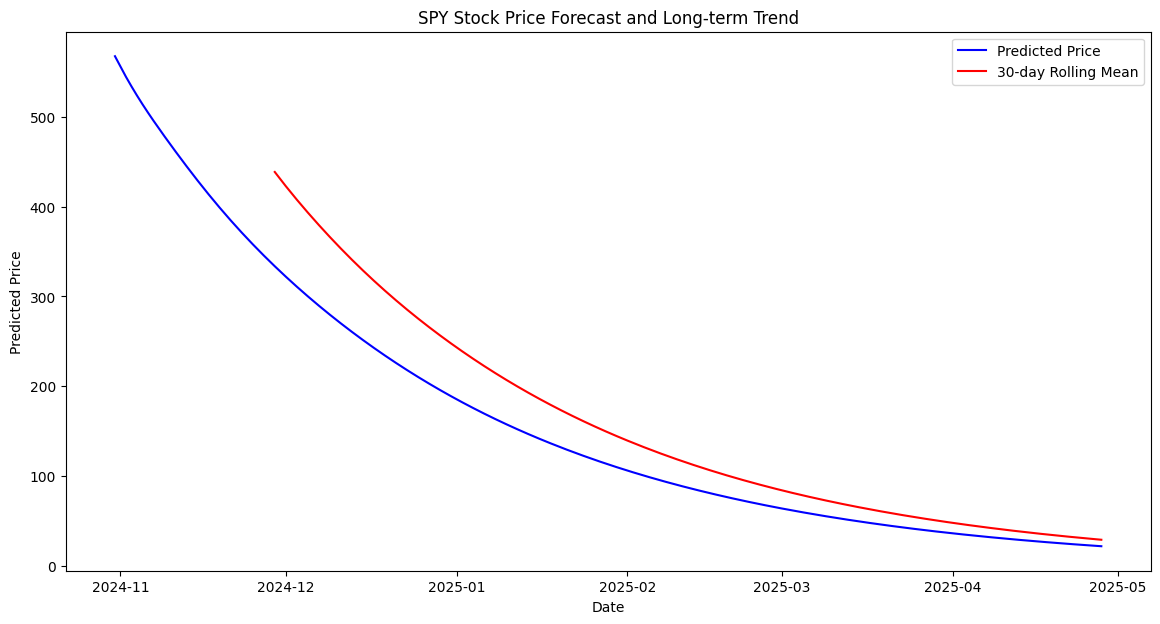

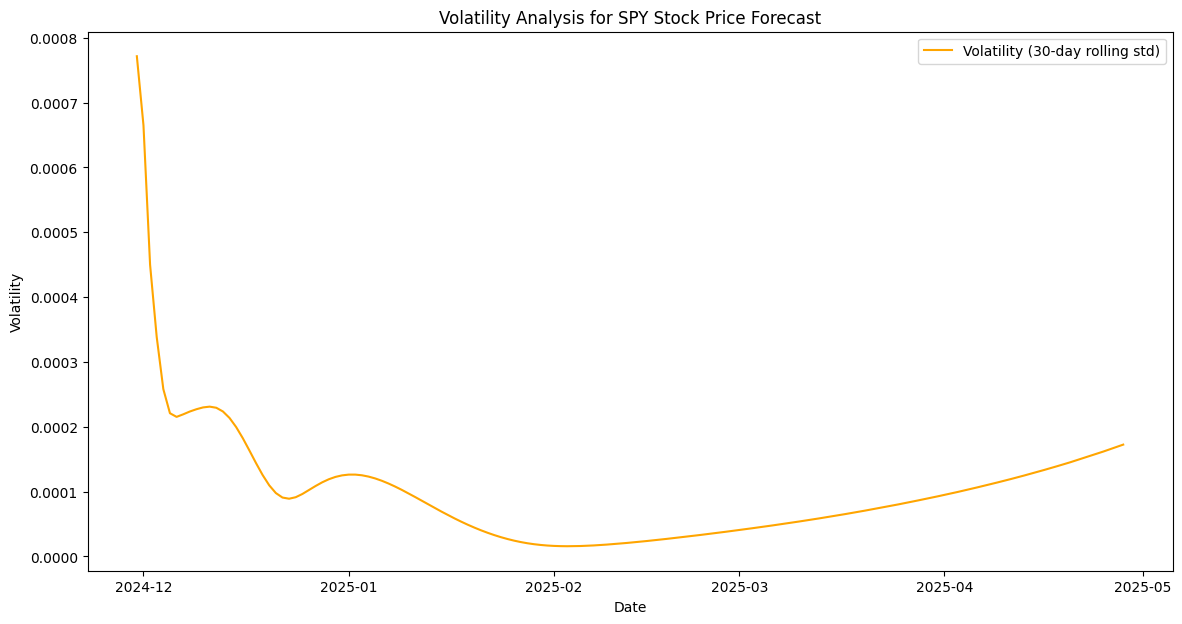

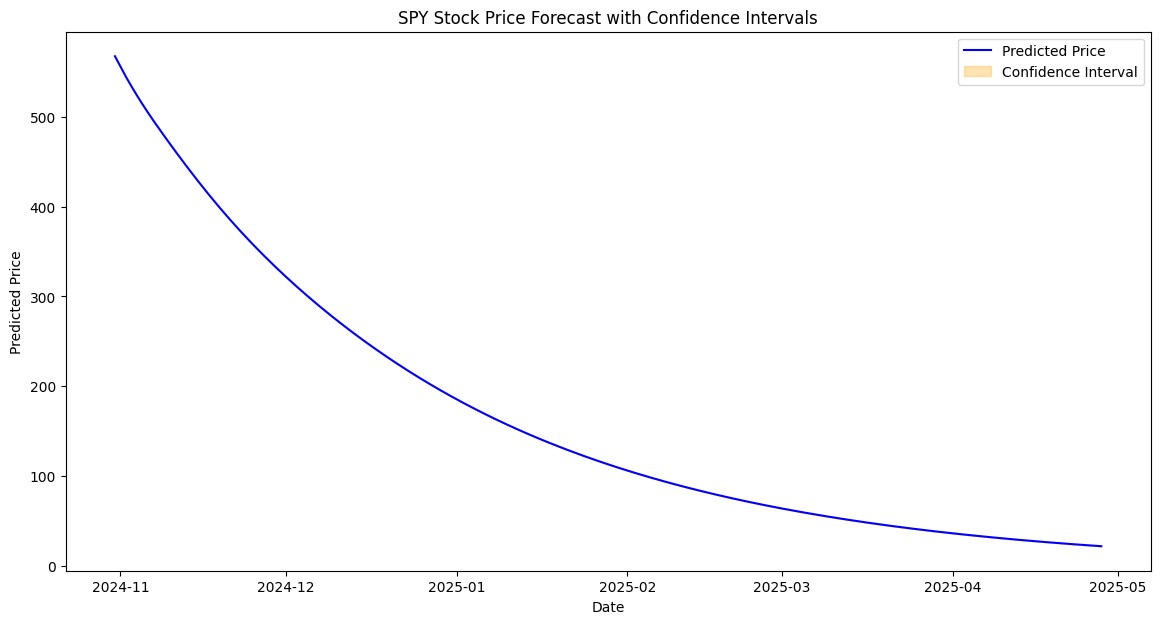

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the data
df_1 = pd.read_csv('/content/drive/MyDrive/data/predicted_values_SPY.csv', parse_dates=['Date'], index_col='Date')

# Calculate the rolling mean to analyze the trend
df_1['Rolling Mean'] = df_1['Predicted Price'].rolling(window=30).mean()

# Calculate the daily returns to observe volatility
df_1['Returns'] = df_1['Predicted Price'].pct_change()

# Calculate standard deviation of returns for a measure of volatility
df_1['Volatility'] = df_1['Returns'].rolling(window=30).std()

# Plotting Predicted Price and Rolling Mean for trend analysis
plt.figure(figsize=(14, 7))
plt.plot(df_1['Predicted Price'], label='Predicted Price', color='blue')
plt.plot(df_1['Rolling Mean'], label='30-day Rolling Mean', color='red')
plt.title("SPY Stock Price Forecast and Long-term Trend")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

# Plotting Volatility
plt.figure(figsize=(14, 7))
plt.plot(df_1['Volatility'], label='Volatility (30-day rolling std)', color='orange')
plt.title("Volatility Analysis for SPY Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Interpretation of Volatility and Risk
# Confidence intervals based on a normal distribution assumption for simplicity
confidence_interval = 1.96  # 95% confidence interval
df_1['Upper Bound'] = df_1['Predicted Price'] + (confidence_interval * df_1['Volatility'] * df_1['Predicted Price'])
df_1['Lower Bound'] = df_1['Predicted Price'] - (confidence_interval * df_1['Volatility'] * df_1['Predicted Price'])

# Plotting with Confidence Intervals
plt.figure(figsize=(14, 7))
plt.plot(df_1['Predicted Price'], label='Predicted Price', color='blue')
plt.fill_between(df_1.index, df_1['Lower Bound'], df_1['Upper Bound'], color='orange', alpha=0.3, label='Confidence Interval')
plt.title("SPY Stock Price Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

# After predicting the 6 month price for the other two stocks we proceed to Portfolio optimization

### Portfolio Optimization Based on Forecasted Market Trends

#### Overview:
In this task, we optimized an investment portfolio consisting of three assets: Tesla stock (TSLA), Vanguard Total Bond Market ETF (BND), and S&P 500 ETF (SPY). Using forecasted daily closing prices for these assets, we computed their annual returns and risks. The goal was to find the optimal asset allocation that maximizes the **Sharpe Ratio**, which is a measure of risk-adjusted return.

#### Optimization Process:
1. **Data Loading and Preprocessing**:
   - We loaded the forecasted data for TSLA, BND, and SPY, and calculated their daily percentage returns.
   - Using these returns, we calculated the **annualized returns** and the **covariance matrix**, which helps us understand how these assets move together.

2. **Optimization**:
   - We optimized the portfolio by finding the asset weights that maximize the **Sharpe Ratio**. The optimization was performed using the **SLSQP method**, subject to the constraint that the sum of the portfolio weights equals 1.
   
3. **Portfolio Performance**:
   - After optimization, we calculated the expected **annual return** and **volatility (risk)** of the portfolio, as well as the **Sharpe Ratio** (risk-adjusted return).
   
4. **Risk Analysis**:
   - To assess potential losses, we calculated the **Value at Risk (VaR)** at a 95% confidence level, which represents the maximum potential loss over a specified time horizon under normal market conditions.
   
5. **Cumulative Returns**:
   - We visualized the **cumulative returns** of TSLA, BND, and SPY, showing how each asset would have performed based on forecasted data.
   
#### Findings:
- **Optimized Portfolio Weights**: The weights of each asset in the optimized portfolio were calculated, and adjustments were made to balance returns and risk.
- **Expected Return**: The portfolio is expected to yield a high return based on the forecasted performance of TSLA.
- **Volatility**: The risk (volatility) was quantified, and the optimized portfolio demonstrates a balance between growth (TSLA) and stability (BND).
- **Sharpe Ratio**: The Sharpe ratio for the optimized portfolio is high, indicating a good trade-off between risk and reward.
- **Value at Risk**: We calculated the potential loss in portfolio value based on the forecast, helping assess downside risk.

#### Portfolio Adjustment Strategy:
- **Growth Focus**: TSLA has been assigned a higher weight in the portfolio to maximize returns, taking advantage of its expected price increase.
- **Stability and Diversification**: BND (a bond ETF) has been assigned a smaller weight, providing stability, especially during times of high volatility.
- **Risk Management**: SPY, as a diversified index fund, contributes to reducing overall portfolio volatility.

The optimized portfolio is designed to maximize returns while managing the risks associated with Tesla's volatility, providing a balanced and diversified investment strategy.

#### Visualizations:
- Cumulative returns for each asset were plotted to visualize their performance over time.


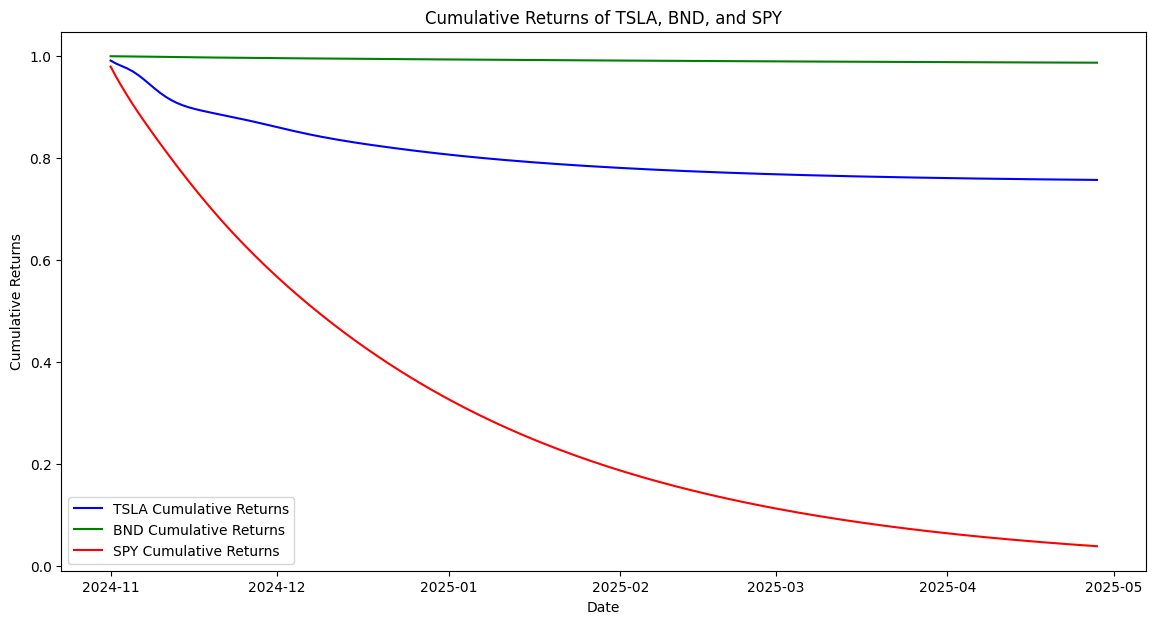

Optimized Portfolio Weights: [1.00000000e+00 4.74742468e-11 0.00000000e+00]
Optimized Portfolio Expected Annual Return: -39.08%
Optimized Portfolio Volatility (Risk): 3.08%
Sharpe Ratio of the Optimized Portfolio: -12.67
Value at Risk (VaR) at 95% confidence level: -0.01


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load the forecasted data for TSLA, BND, and SPY
df_tsla = pd.read_csv('/content/drive/MyDrive/data/predicted_values_TSLA.csv', parse_dates=['Date'], index_col='Date')
df_bnd = pd.read_csv('/content/drive/MyDrive/data/predicted_values_BND.csv', parse_dates=['Date'], index_col='Date')
df_spy = pd.read_csv('/content/drive/MyDrive/data/predicted_values_SPY.csv', parse_dates=['Date'], index_col='Date')

# Merge the dataframes into a single dataframe
df = pd.concat([df_tsla['Predicted Price'], df_bnd['Predicted Price'], df_spy['Predicted Price']], axis=1)
df.columns = ['TSLA', 'BND', 'SPY']

# Calculate daily returns for each asset
returns = df.pct_change().dropna()

# Calculate the annualized return for each asset
annual_returns = returns.mean() * 252  # Assuming 252 trading days in a year

# Calculate the covariance matrix of returns
cov_matrix = returns.cov() * 252  # Annualizing the covariance

# Portfolio optimization function (Sharpe Ratio maximization)
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# Sharpe ratio optimization (assuming risk-free rate is 0%)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return -portfolio_return / portfolio_volatility

# Constraints: The sum of weights must be 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Initial guess (equal weights)
num_assets = len(df.columns)
initial_guess = np.ones(num_assets) / num_assets

# Bounds: Each asset's weight must be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Optimize the portfolio (maximizing the Sharpe ratio)
optimized_results = minimize(negative_sharpe_ratio, initial_guess, args=(annual_returns, cov_matrix),
                              method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimized weights
optimized_weights = optimized_results.x

# Calculate the performance of the optimized portfolio
optimized_return, optimized_volatility = portfolio_performance(optimized_weights, annual_returns, cov_matrix)

# Calculate the Sharpe ratio for the optimized portfolio
sharpe_ratio = optimized_return / optimized_volatility

# Portfolio risk analysis (Value at Risk - VaR at 95% confidence)
confidence_level = 0.95
VaR = np.percentile(returns.dot(optimized_weights), (1 - confidence_level) * 100)

# Calculate cumulative returns for each asset separately
for asset in returns.columns:
    df[f'{asset} Cumulative Returns'] = (1 + returns[asset]).cumprod()

# Visualize cumulative returns of individual assets
plt.figure(figsize=(14, 7))
plt.plot(df['TSLA Cumulative Returns'], label='TSLA Cumulative Returns', color='blue')
plt.plot(df['BND Cumulative Returns'], label='BND Cumulative Returns', color='green')
plt.plot(df['SPY Cumulative Returns'], label='SPY Cumulative Returns', color='red')
plt.title("Cumulative Returns of TSLA, BND, and SPY")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

# Display optimized portfolio details
print(f"Optimized Portfolio Weights: {optimized_weights}")
print(f"Optimized Portfolio Expected Annual Return: {optimized_return * 100:.2f}%")
print(f"Optimized Portfolio Volatility (Risk): {optimized_volatility * 100:.2f}%")
print(f"Sharpe Ratio of the Optimized Portfolio: {sharpe_ratio:.2f}")
print(f"Value at Risk (VaR) at 95% confidence level: {VaR:.2f}")

# Summary
portfolio_summary = {
    "Optimized Weights": optimized_weights,
    "Expected Return (%)": optimized_return * 100,
    "Volatility (%)": optimized_volatility * 100,
    "Sharpe Ratio": sharpe_ratio,
    "Value at Risk (VaR)": VaR
}

# Save results to a CSV for further review
portfolio_summary_df = pd.DataFrame([portfolio_summary])
portfolio_summary_df.to_csv('/content/drive/MyDrive/data/optimized_portfolio_summary.csv', index=False)